In [1]:
import os
import sys
from datetime import datetime
from typing import List, Union
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
from pathlib import Path
import holidays
import pickle
import torch

In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hype

In [3]:
def check_na(df):
    """
    percentage of rows containing NaN data
    """
    return df.isna().sum() * 100 / len(df)

In [4]:
df = pd.read_csv('data/merged_2point_utf8.csv')

/tmp/ipykernel_11464/3719225742.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/merged_2point_utf8.csv')


In [5]:
df['time'] = pd.to_datetime(df['time'])

In [6]:
df.sort_values(by=['time'], inplace=True)

In [7]:
df['time_cleansing'] = df['time'].apply(lambda x: x.replace(minute=int(x.minute/10) * 10 + (0 if x.minute % 10 <= 4 else 5), second=0))

In [8]:
for item_id in df['item_id'].unique():
    print(df[df['item_id'] == item_id]['time_cleansing'].min())

2022-12-09 16:00:00
2022-12-09 16:25:00
2022-12-12 14:20:00
2022-12-12 14:30:00
2022-12-12 15:20:00
2022-12-12 15:50:00
2022-12-12 16:30:00
2023-01-10 12:10:00
2023-01-10 14:55:00


In [9]:
df_cleansing = df[df['time_cleansing'] >= datetime(2023, 1, 11)][['item_id', 'time_cleansing', 'NH3', 'H2S', 'TVOCs', 'temperature', 'humidity', 'winddirection', 'windspeed', 'atm', 'ou']]

In [10]:
df_cleansing.sort_values(by=['time_cleansing', 'item_id'], inplace=True)

In [11]:
df_cleansing.reset_index(drop=True, inplace=True)

In [12]:
df_cleansing['ou'] = df_cleansing['ou'].apply(lambda x: str(x).replace(',', '')).astype(float)

In [13]:
df_cleansing['date'] = df_cleansing['time_cleansing'].apply(lambda x: x.date())

In [14]:
df_cleansing['time_idx'] = df_cleansing['time_cleansing'].rank(method='dense').astype(int)

In [15]:
train_df = df_cleansing[df_cleansing['time_cleansing'] < datetime(2023, 6, 1)]
test_df = df_cleansing[df_cleansing['time_cleansing'] >= datetime(2023, 6, 1)]

In [16]:
train_df.head()

item_id      time_cleansing    NH3    H2S  TVOCs  temperature  humidity  \
0      101 2023-01-11 00:10:00  0.414  0.251  0.094         -1.7       8.8   
1      102 2023-01-11 00:10:00  0.667  0.230  0.008         -1.8       8.9   
2      103 2023-01-11 00:10:00  0.626  0.267  0.003          0.5       8.0   
3      104 2023-01-11 00:10:00  0.285  0.202  0.008         -0.6       8.5   
4      105 2023-01-11 00:10:00  0.523  0.303  0.023         -1.4       9.0   

   winddirection  windspeed  atm   ou        date  time_idx  
0              1        0.3    0  1.8  2023-01-11         1  
1              1        0.3    0  2.2  2023-01-11         1  
2              0        0.0    0  3.9  2023-01-11         1  
3              0        0.0    0  1.6  2023-01-11         1  
4              0        0.0    0  2.3  2023-01-11         1

In [17]:
test_df.head()

item_id      time_cleansing    NH3    H2S  TVOCs  temperature  \
357881      101 2023-06-01 00:10:00  0.232  0.000  0.073         20.3   
357882      102 2023-06-01 00:10:00  0.498  0.166  0.000         19.4   
357883      103 2023-06-01 00:10:00  0.493  0.205  0.000         21.8   
357884      104 2023-06-01 00:10:00  0.154  0.116  0.000         20.5   
357885      105 2023-06-01 00:10:00  0.341  0.254  0.021         21.1   

        humidity  winddirection  windspeed  atm   ou        date  time_idx  
357881       7.3              1        0.1    0  2.8  2023-06-01     40255  
357882       8.1              1        0.2    0  3.1  2023-06-01     40255  
357883       7.0              0        0.0    0  2.5  2023-06-01     40255  
357884       7.4              0        0.0    0  3.5  2023-06-01     40255  
357885       7.1              0        0.0    0  2.8  2023-06-01     40255

In [18]:
check_na(train_df)

item_id           0.0
time_cleansing    0.0
NH3               0.0
H2S               0.0
TVOCs             0.0
temperature       0.0
humidity          0.0
winddirection     0.0
windspeed         0.0
atm               0.0
ou                0.0
date              0.0
time_idx          0.0
dtype: float64

In [19]:
train_df['ou'] = train_df['ou'].apply(lambda x: 30.0 if x > 30.0 else x)
test_df['ou'] = test_df['ou'].apply(lambda x: 30.0 if x > 30.0 else x)

/tmp/ipykernel_11464/908876923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ou'] = train_df['ou'].apply(lambda x: 30.0 if x > 30.0 else x)
/tmp/ipykernel_11464/908876923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ou'] = test_df['ou'].apply(lambda x: 30.0 if x > 30.0 else x)


In [20]:
train_df.sort_values(by=['ou'], ascending=False)

item_id      time_cleansing    NH3    H2S  TVOCs  temperature  \
297508      101 2023-05-08 07:25:00  0.310  0.094  0.000         11.1   
310078      107 2023-05-13 05:50:00  0.647  0.232  0.016         12.0   
308244      107 2023-05-12 12:30:00  0.373  0.146  0.442         22.8   
309243      107 2023-05-12 21:55:00  0.638  0.185  0.213         16.2   
308299      108 2023-05-12 13:00:00  0.000  0.000  0.044         24.5   
...         ...                 ...    ...    ...    ...          ...   
143011      107 2023-03-08 09:40:00  0.000  0.000  0.000          0.0   
143012      108 2023-03-08 09:40:00  0.000  0.000  0.000          0.0   
176195      107 2023-03-21 10:25:00  0.000  0.000  0.000          0.0   
160717      103 2023-03-15 08:40:00  0.000  0.000  0.000          0.0   
160716      102 2023-03-15 08:40:00  0.000  0.000  0.000          0.0   

        humidity  winddirection  windspeed  atm    ou        date  time_idx  
297508       7.4             15        0.9    0  30.0  2023-05-08     33480  
310078       9.0             12        0.7    0  30.0  2023-05-13     34890  
308244       2.8             11        1.5    0  30.0  2023-05-12     34684  
309243       7.0             14        0.3    0  30.0  2023-05-12     34797  
308299       2.6              0        0.0    0  30.0  2023-05-12     34690  
...          ...            ...        ...  ...   ...         ...       ...  
143011       0.0              0        0.0    0   0.0  2023-03-08     16130  
143012       0.0              0        0.0    0   0.0  2023-03-08     16130  
176195       0.0              0        0.0    0   0.0  2023-03-21     19857  
160717       0.0              0        0.0    0   0.0  2023-03-15     18120  
160716       0.0              0        0.0    0   0.0  2023-03-15     18120  

[357881 rows x 13 columns]

<Axes: xlabel='date', ylabel='ou'>

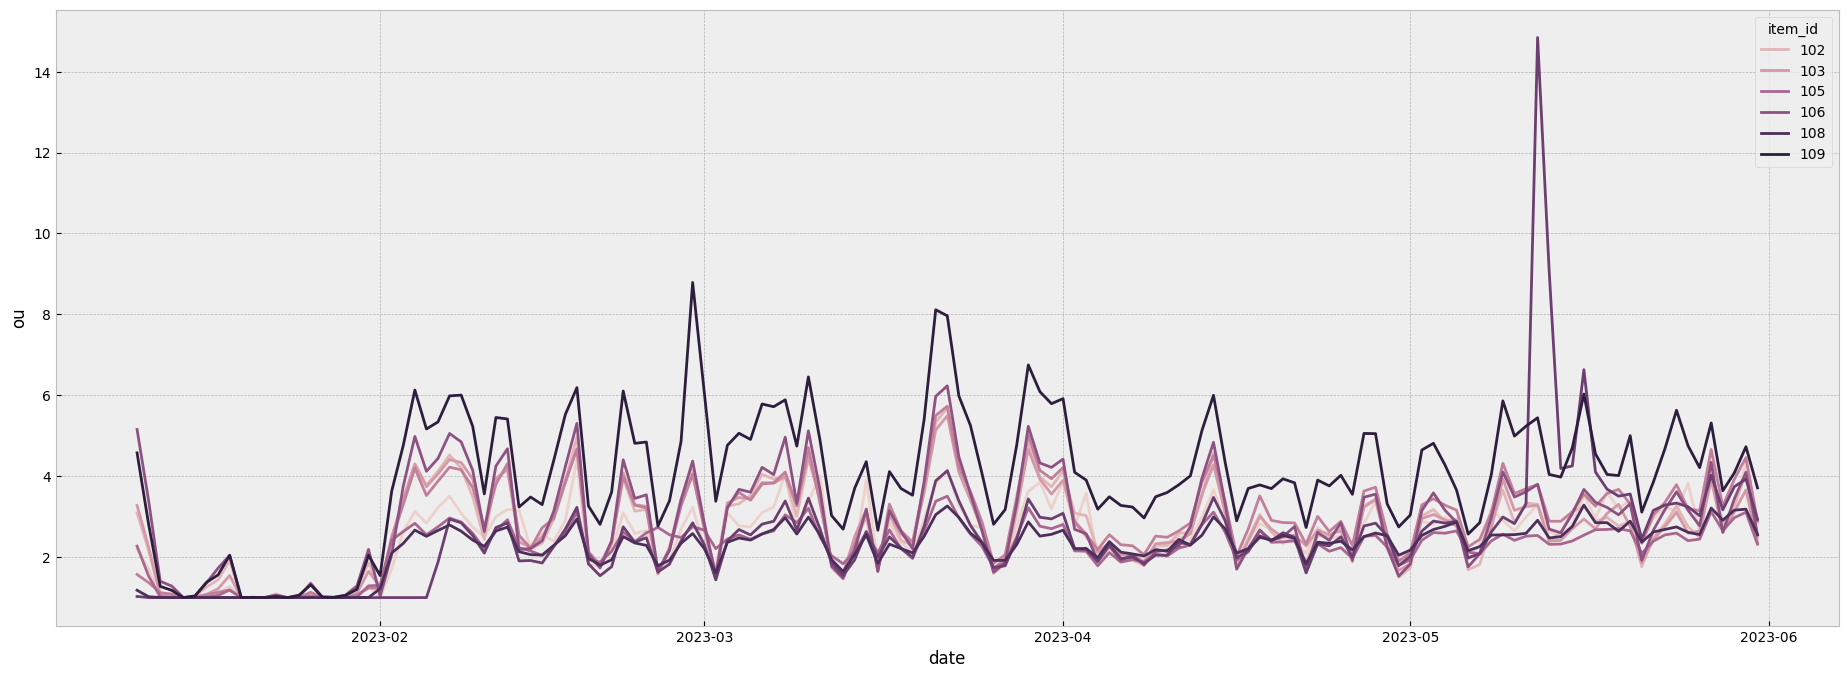

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='ou', hue='item_id', data=(train_df.groupby(['date', 'item_id']).ou.mean().to_frame()))

<Axes: xlabel='date', ylabel='ou'>

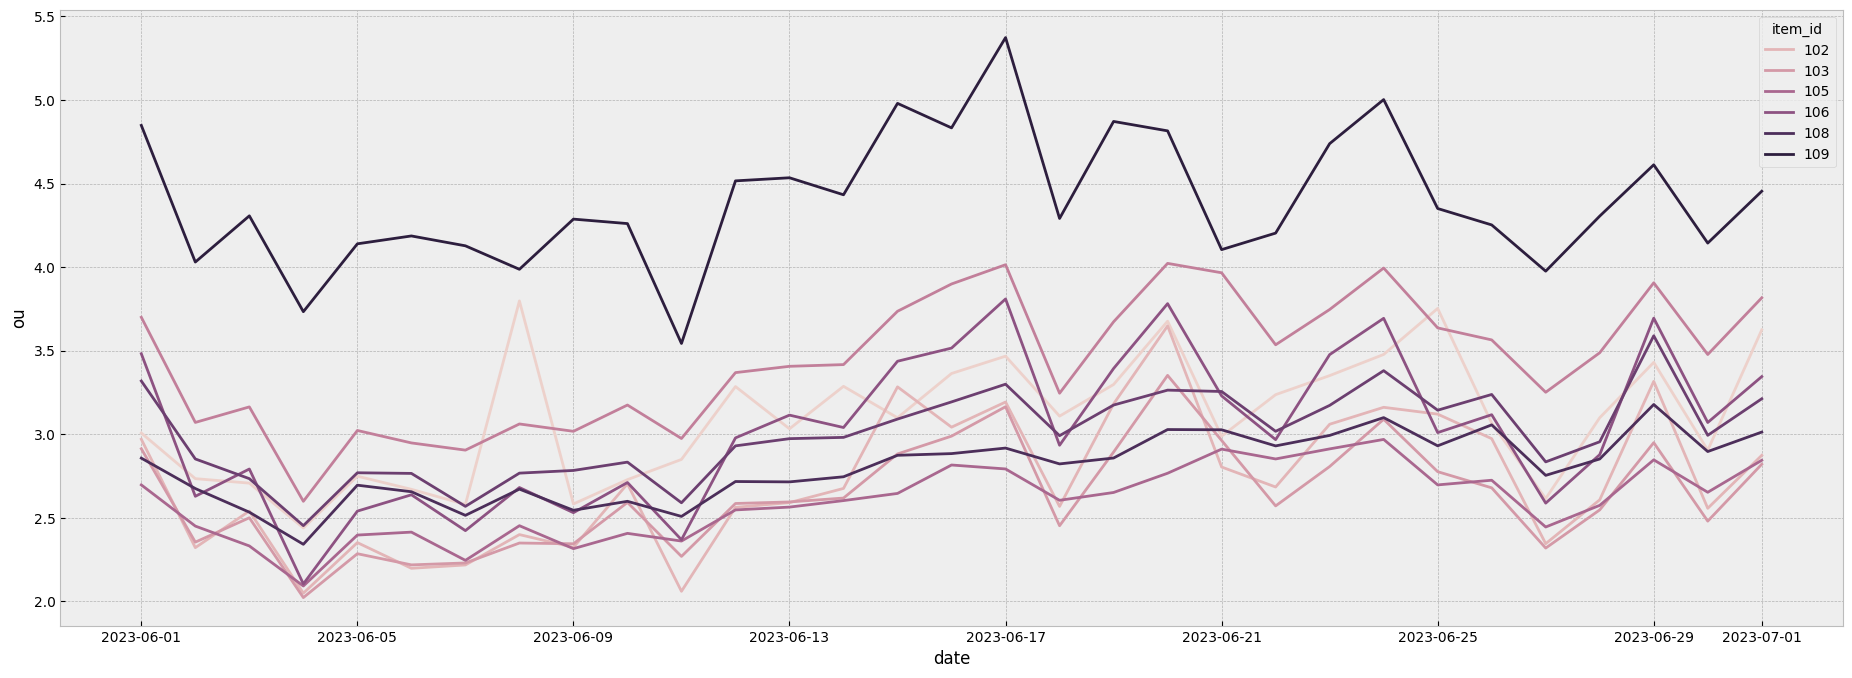

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='ou', hue='item_id', data=(test_df.groupby(['date', 'item_id']).ou.mean().to_frame()))

In [23]:
# for column in ['day', 'week', 'month']:
df = train_df.groupby(['date', 'item_id']).ou.sum().unstack()
df

item_id        101     102     103     104    105     106     107    108  \
date                                                                       
2023-01-11   625.8   879.2   928.1   446.3  645.3  1453.5   291.9  334.3   
2023-01-12   489.0   614.7   634.2   388.8  434.2   963.1   284.0  286.7   
2023-01-13   284.4   306.6   302.4   318.2  287.5   398.8   284.0  283.8   
2023-01-14   322.1   311.2   286.6   304.3  283.0   363.4   284.0  284.0   
2023-01-15   283.0   284.0   282.0   284.0  284.0   284.0   284.0  285.0   
...            ...     ...     ...     ...    ...     ...     ...    ...   
2023-05-27  1107.8  1144.7  1102.8  1324.1  883.9  1225.3  1142.7  905.9   
2023-05-28   819.4   798.3   736.3   922.6  750.7   741.6   899.7  824.3   
2023-05-29   892.4   938.5   885.8  1111.6  842.1   971.0  1055.3  897.8   
2023-05-30  1232.2  1146.8  1036.2  1266.3  880.0  1163.2  1115.9  904.6   
2023-05-31   803.0   706.2   669.5   820.3  658.7   723.6   829.3  724.8   

item_id        109  
date                
2023-01-11  1281.6  
2023-01-12   789.2  
2023-01-13   360.1  
2023-01-14   331.5  
2023-01-15   282.0  
...            ...  
2023-05-27  1499.1  
2023-05-28  1023.0  
2023-05-29  1151.5  
2023-05-30  1333.5  
2023-05-31  1043.0  

[141 rows x 9 columns]

In [24]:
freq = "5Minute"  # 1 day
sampling_interval = 24*60*60  # in seconds
sampling_frequency = 1.0 / sampling_interval  # sampling freq in Hz

Text(0, 0.5, 'PSD [V**2/Hz]')

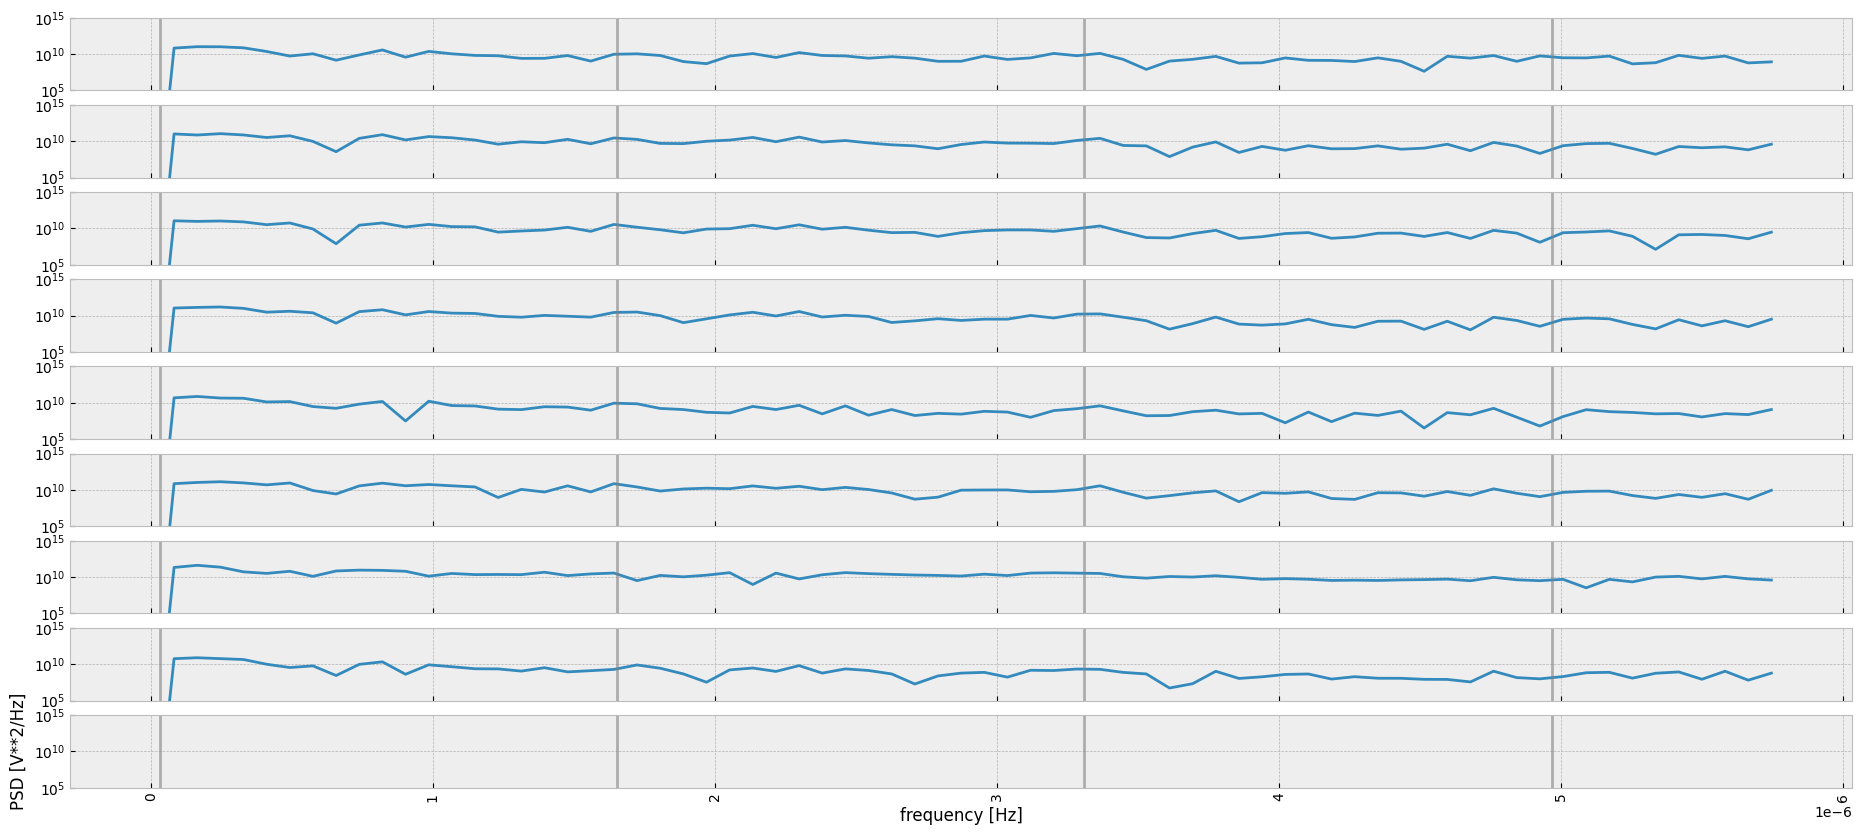

In [25]:
fig, axes = plt.subplots(df.shape[1], 1, figsize=(23,10), sharex=True)

for ax, product in zip(axes, df.columns):

    f, Pxx = signal.periodogram(df[product], fs=sampling_frequency) 
    ax.semilogy(f, Pxx)
    ax.set_ylim([1e5, 1e15])
    
    for freq in [1.0/(sampling_interval*365), 1.0/(sampling_interval*7), 1.0/(sampling_interval*3.5), 1.0/(sampling_interval*2.33)]:
        ax.vlines(x=freq, color="gray", ymin=1e5, ymax=1e15, alpha=0.6)

plt.xticks(rotation=90)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

In [26]:
max_prediction_length = 15*288 # a whole year
max_encoder_length = 15*288

# For training/evaluation splits
training_cutoff = train_df["time_idx"].max() - max_prediction_length # validation on 2020

In [27]:
train_df

item_id      time_cleansing    NH3    H2S  TVOCs  temperature  \
0           101 2023-01-11 00:10:00  0.414  0.251  0.094         -1.7   
1           102 2023-01-11 00:10:00  0.667  0.230  0.008         -1.8   
2           103 2023-01-11 00:10:00  0.626  0.267  0.003          0.5   
3           104 2023-01-11 00:10:00  0.285  0.202  0.008         -0.6   
4           105 2023-01-11 00:10:00  0.523  0.303  0.023         -1.4   
...         ...                 ...    ...    ...    ...          ...   
357876      105 2023-05-31 23:55:00  0.328  0.248  0.020         22.0   
357877      106 2023-05-31 23:55:00  0.269  0.135  0.000         21.8   
357878      107 2023-05-31 23:55:00  0.547  0.176  0.017         21.9   
357879      108 2023-05-31 23:55:00  0.000  0.000  0.078         21.6   
357880      109 2023-05-31 23:55:00  0.626  0.000  0.032         21.9   

        humidity  winddirection  windspeed  atm   ou        date  time_idx  
0            8.8              1        0.3    0  1.8  2023-01-11         1  
1            8.9              1        0.3    0  2.2  2023-01-11         1  
2            8.0              0        0.0    0  3.9  2023-01-11         1  
3            8.5              0        0.0    0  1.6  2023-01-11         1  
4            9.0              0        0.0    0  2.3  2023-01-11         1  
...          ...            ...        ...  ...  ...         ...       ...  
357876       7.5             11        0.3    0  2.5  2023-05-31     40254  
357877       7.0              6        0.4    0  2.6  2023-05-31     40254  
357878       7.5              7        0.8    0  2.9  2023-05-31     40254  
357879       7.8              0        0.0    0  2.8  2023-05-31     40254  
357880       7.6              8        1.4    0  3.7  2023-05-31     40254  

[357881 rows x 13 columns]

In [28]:
# Create training set
training_dataset = TimeSeriesDataSet(
    train_df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ou",
    group_ids=['item_id'], # static covariates
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=[
        "time_idx", 'NH3', 'H2S', 'TVOCs', 'temperature', 'humidity', 'winddirection', 'windspeed', 'atm'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['ou'],
    target_normalizer=GroupNormalizer(
        groups=["item_id"], transformation="softplus"
    ),  # use softplus transformation and normalize by group
    lags={'ou': [1, 141]}, # add lagged values of target variable
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [29]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
                                            train_df, # data from which new dataset will be generated
                                            predict=True, # predict the decoder length on the last entries in the time index
                                            stop_randomization=True)

In [30]:
batch_size = 16 
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [31]:
# define callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
#logger = TensorBoardLogger(save_dir='logger')  # logging results to a tensorboard

# create trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    #accelerator='cpu',
    devices=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # run validation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
# Create network from TimeSeriesDataSet
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=13,
    output_size=30,  # number of quantiles
    loss=QuantileLoss(),
    log_interval=10,  # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 43.3k


/home/ubuntu/anaconda3/envs/transformers/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ubuntu/anaconda3/envs/transformers/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [33]:
tft

TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            13
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       16
  	"learning_rate":                     0.03
  	"log_gradient_flow":                 False
  	"log_interval":                      10
  	"log_val_interval":                  10
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"lstm_layers":                       1
  	"max_encoder_length":                4320
  	"monotone_constaints":               {}
  	"o

In [34]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 416   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.9 K 
5  | enc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [35]:
# load the best model w.r.t. the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/ubuntu/anaconda3/envs/transformers/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ubuntu/anaconda3/envs/transformers/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [36]:
best_model_path


'/home/ubuntu/dacon_run/lightning_logs/version_11/checkpoints/epoch=49-step=1500.ckpt'

In [38]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 0.5193580985069275


In [76]:
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


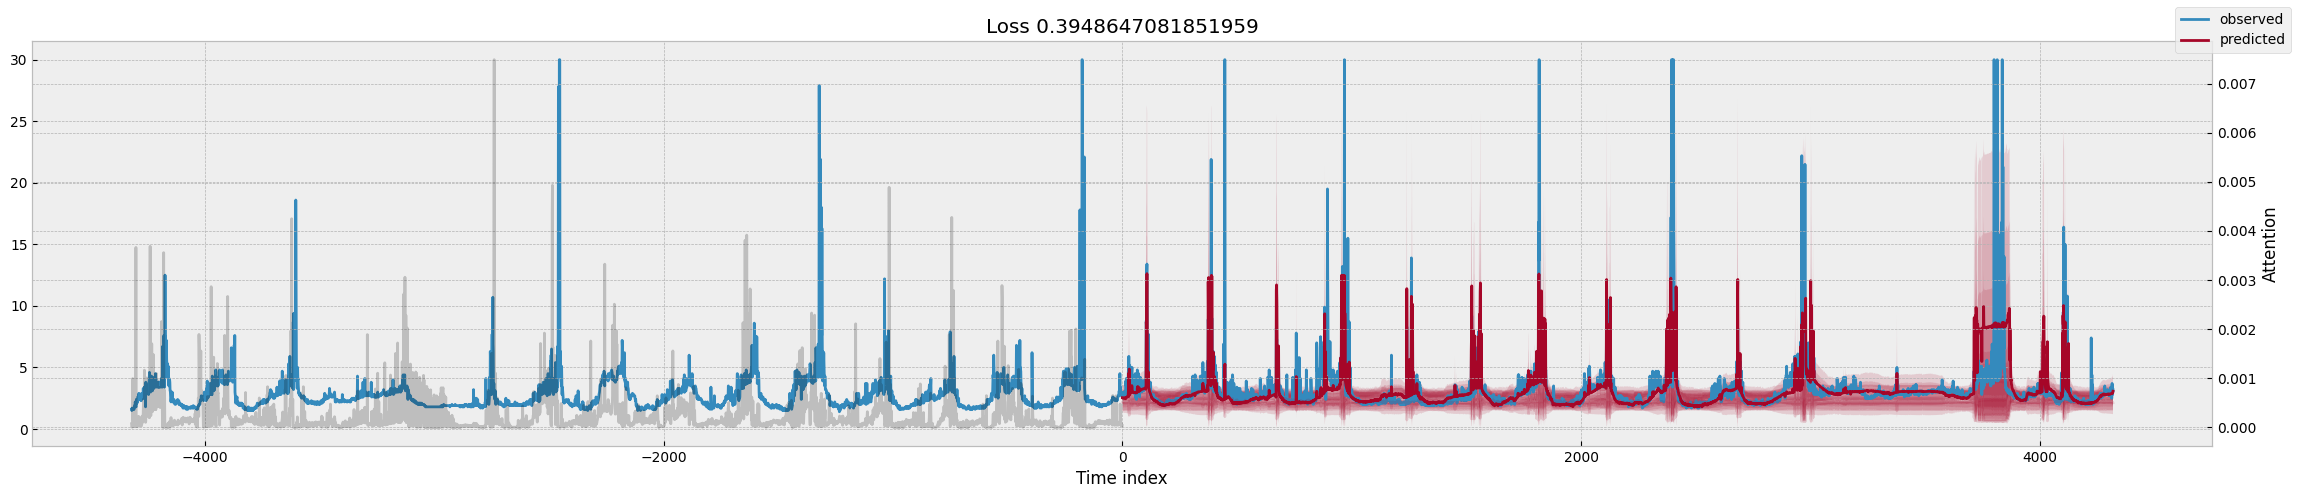

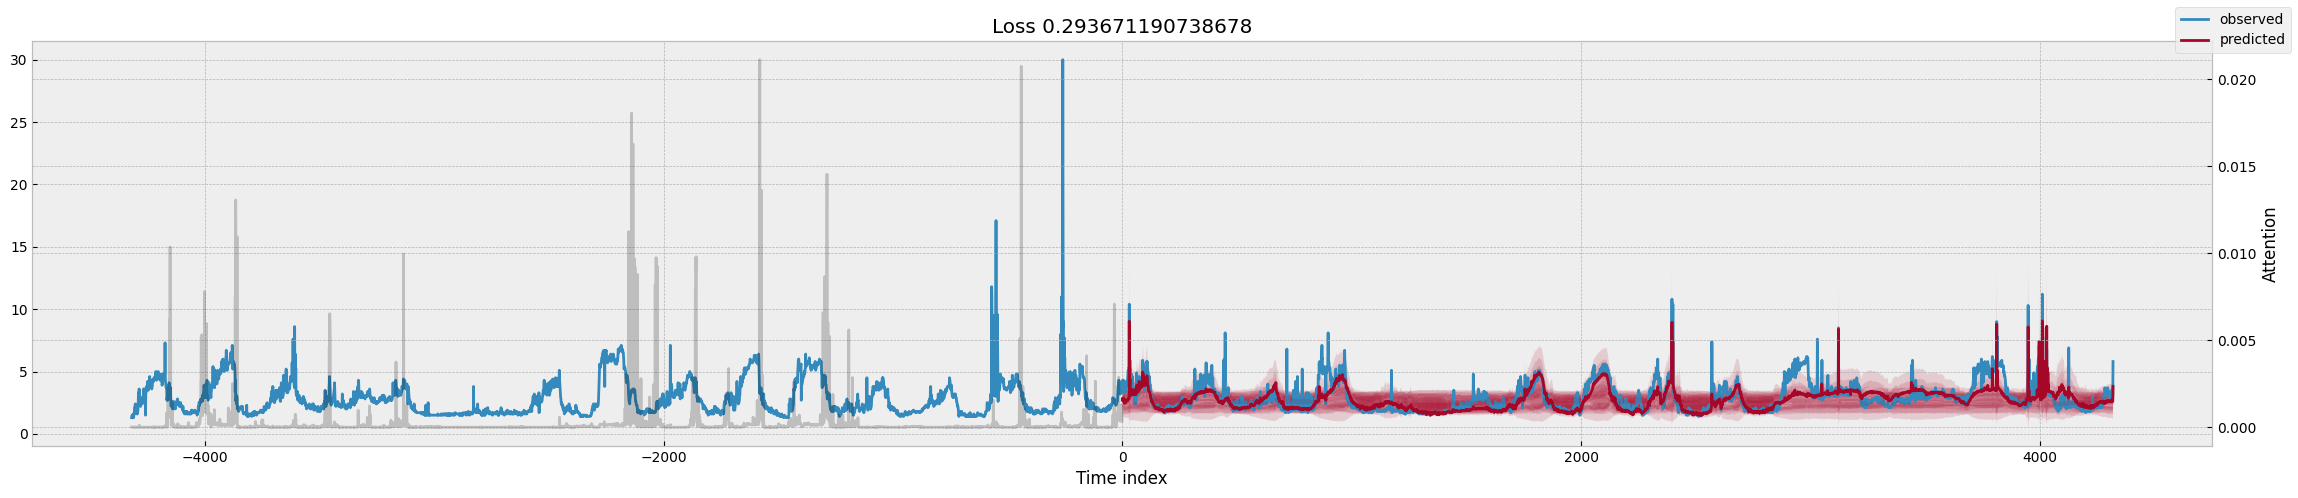

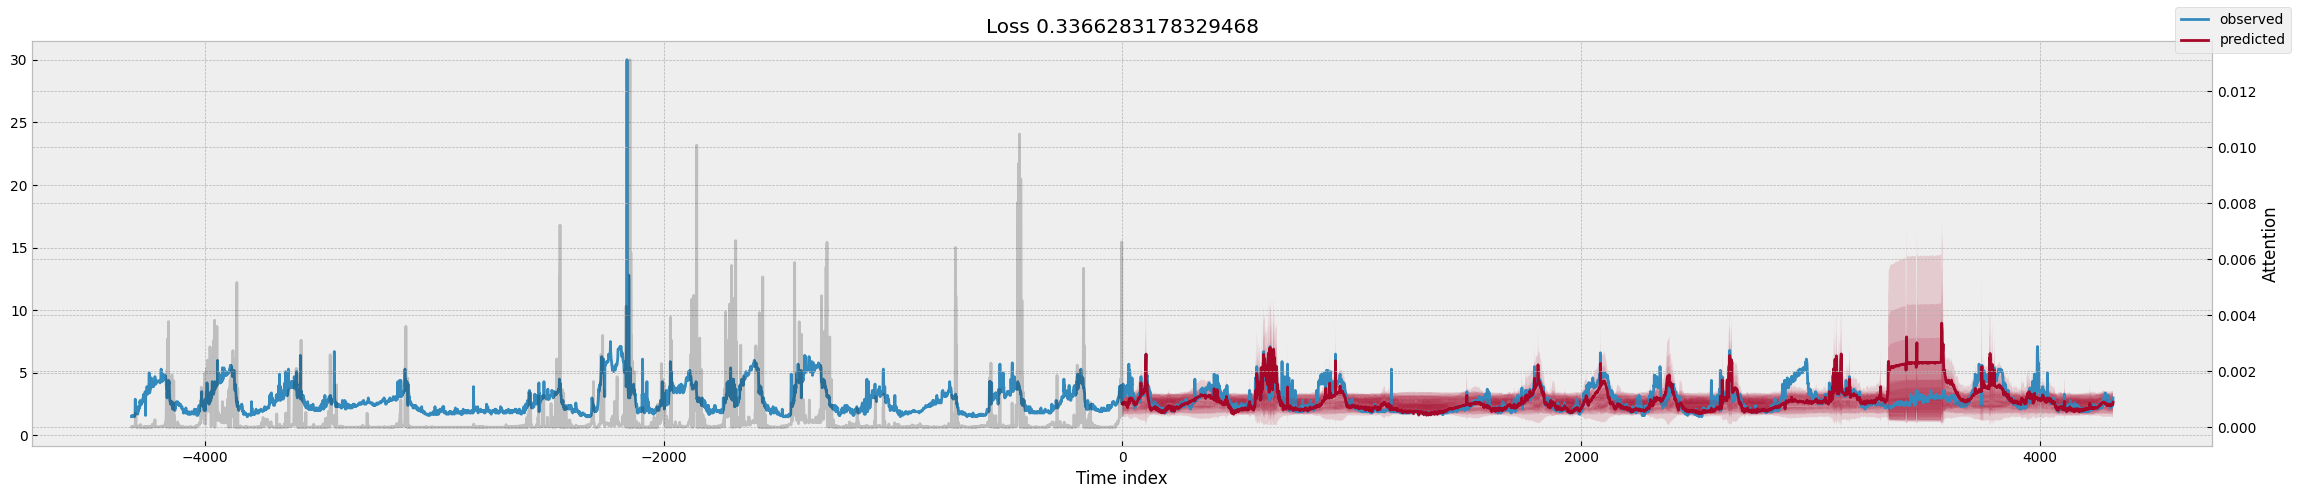

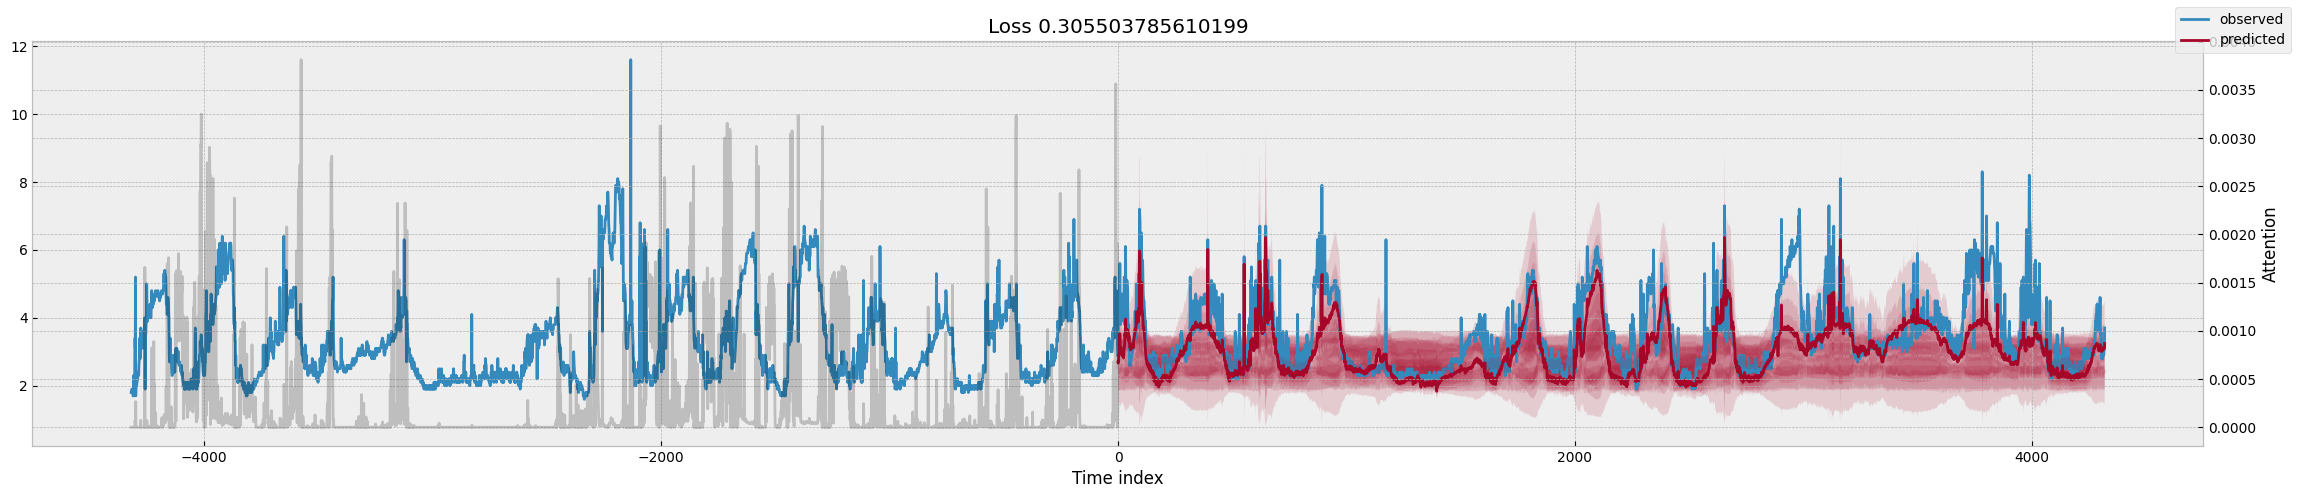

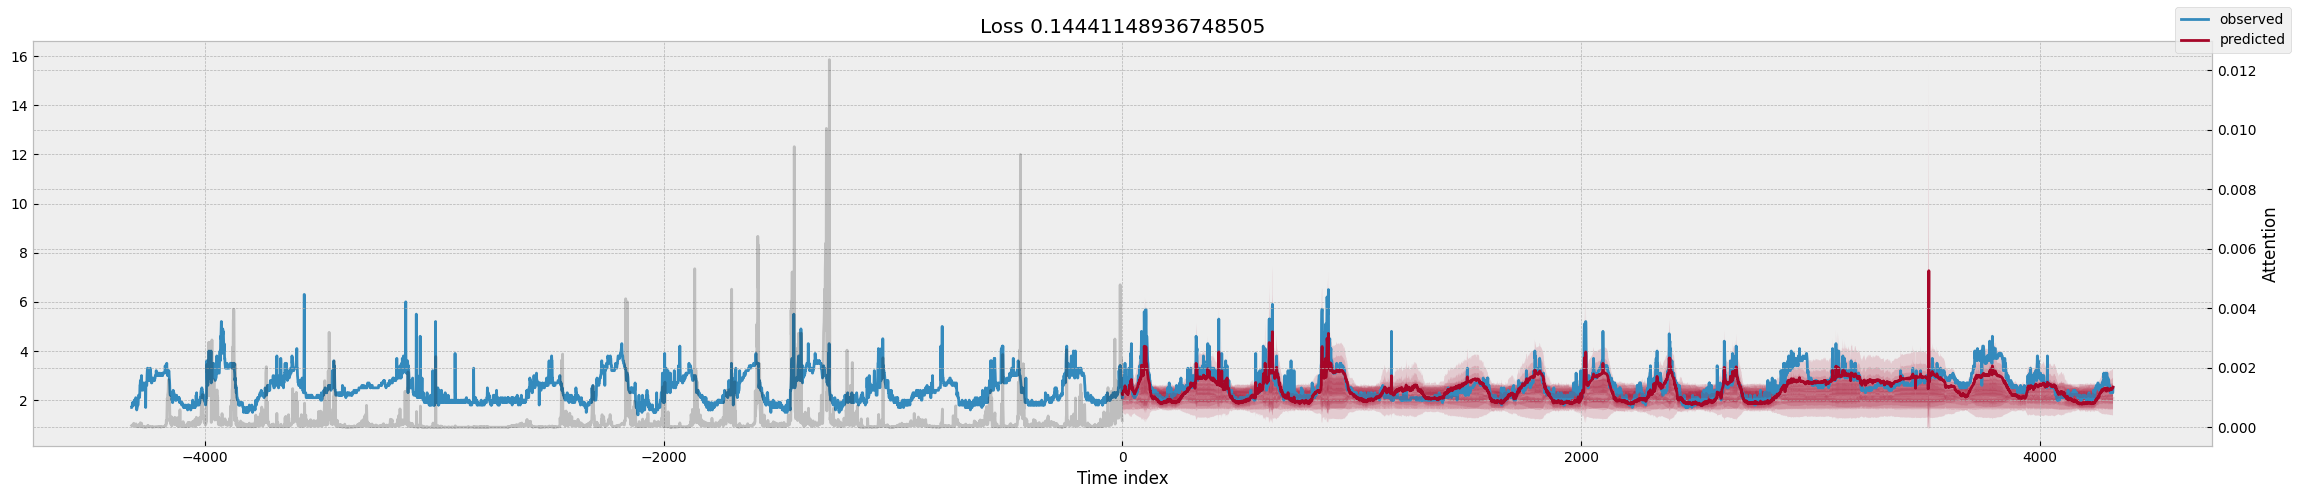

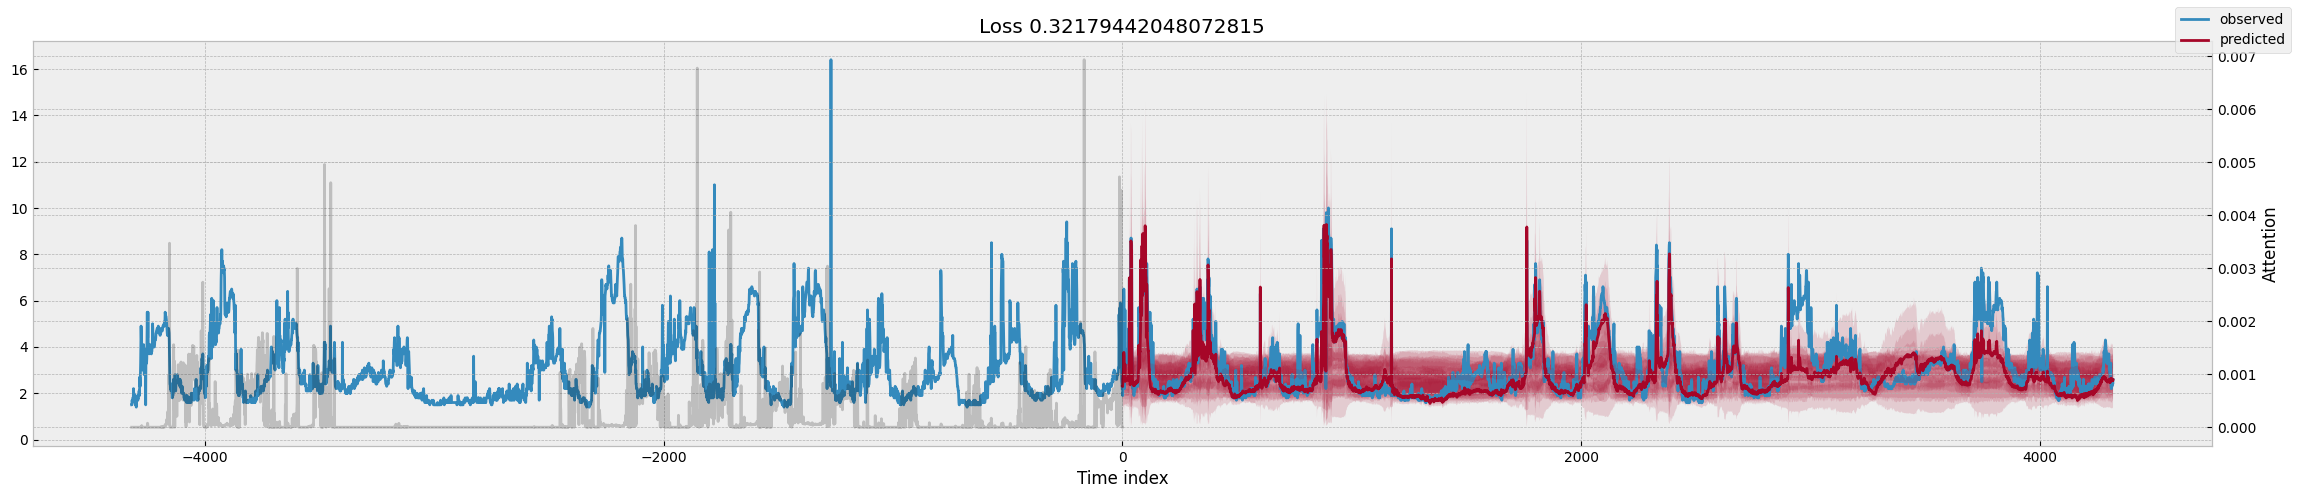

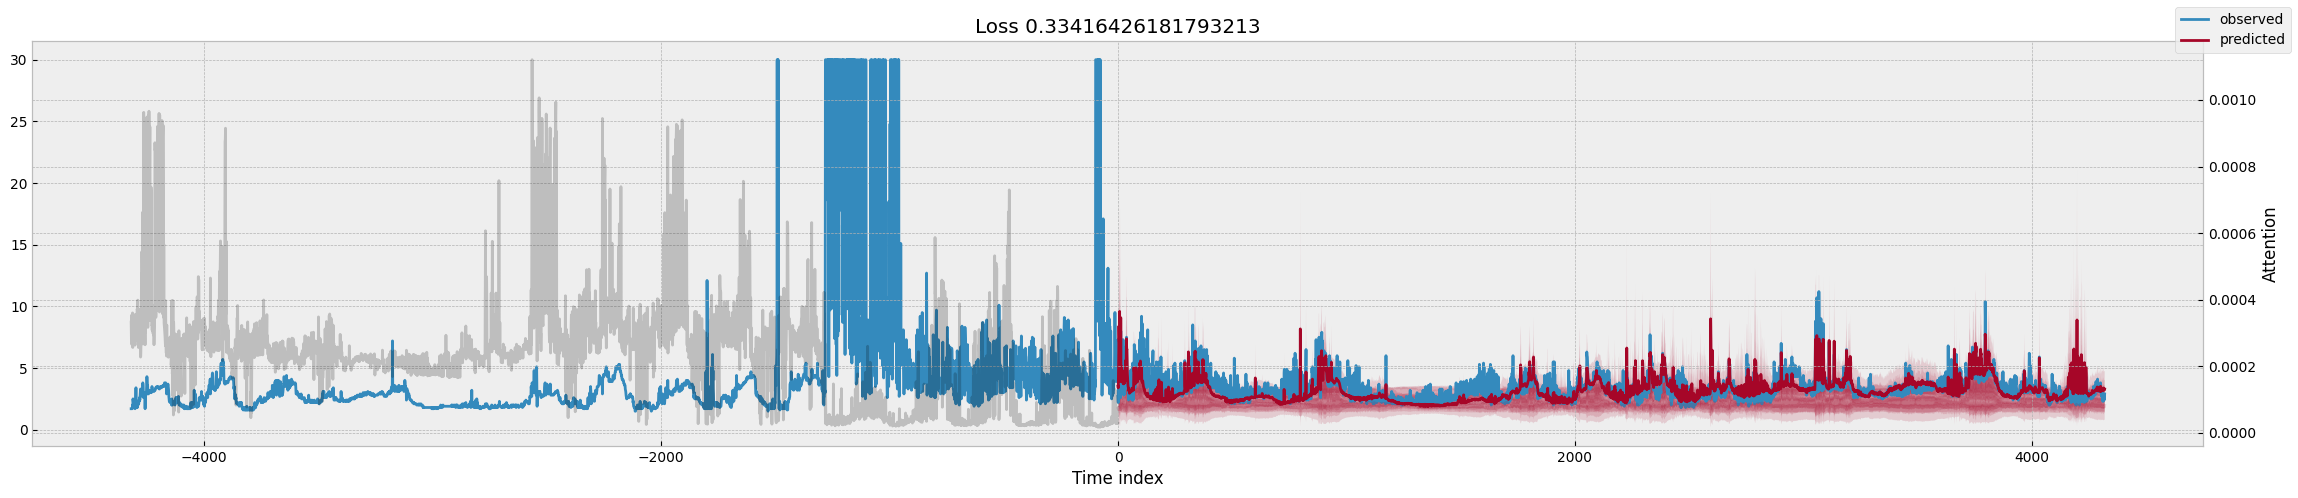

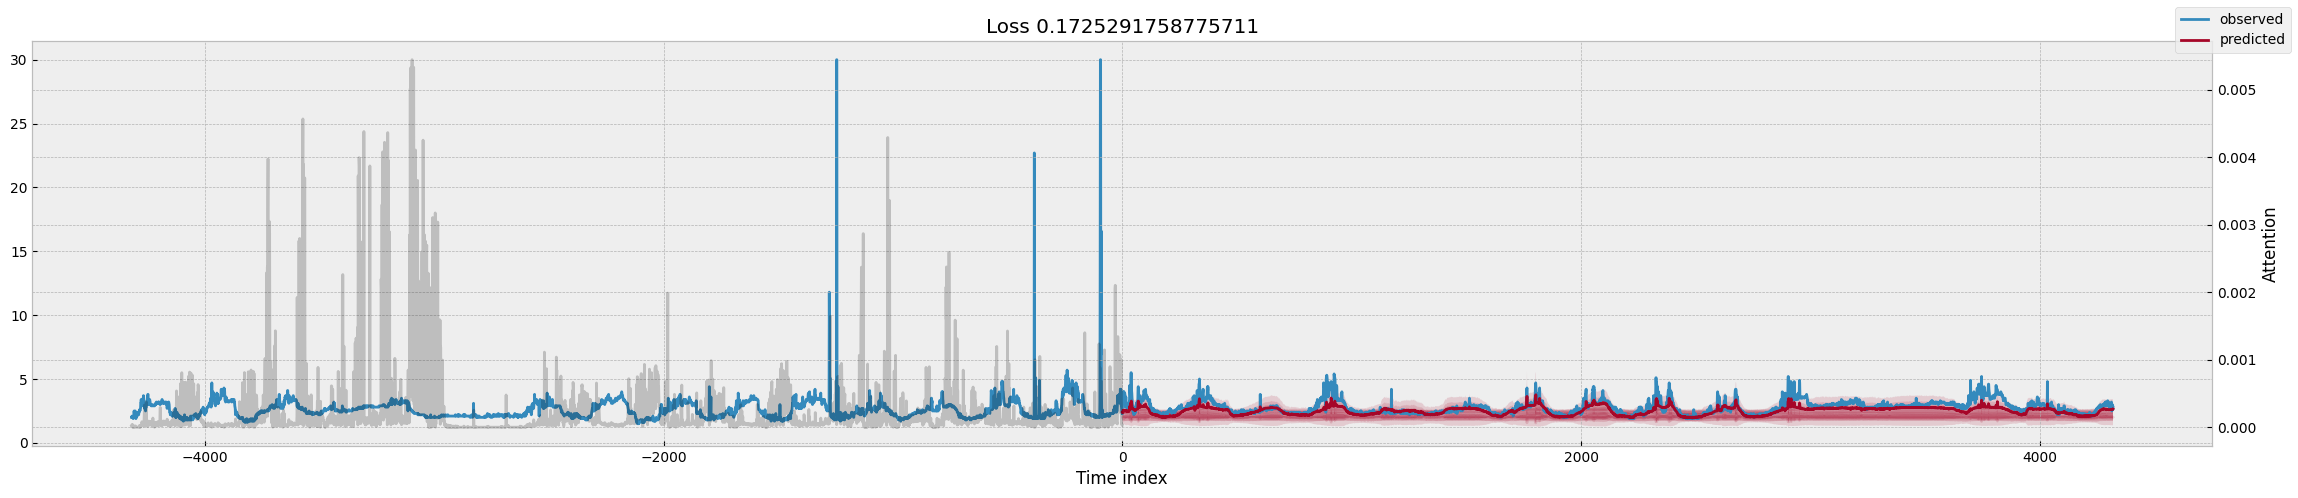

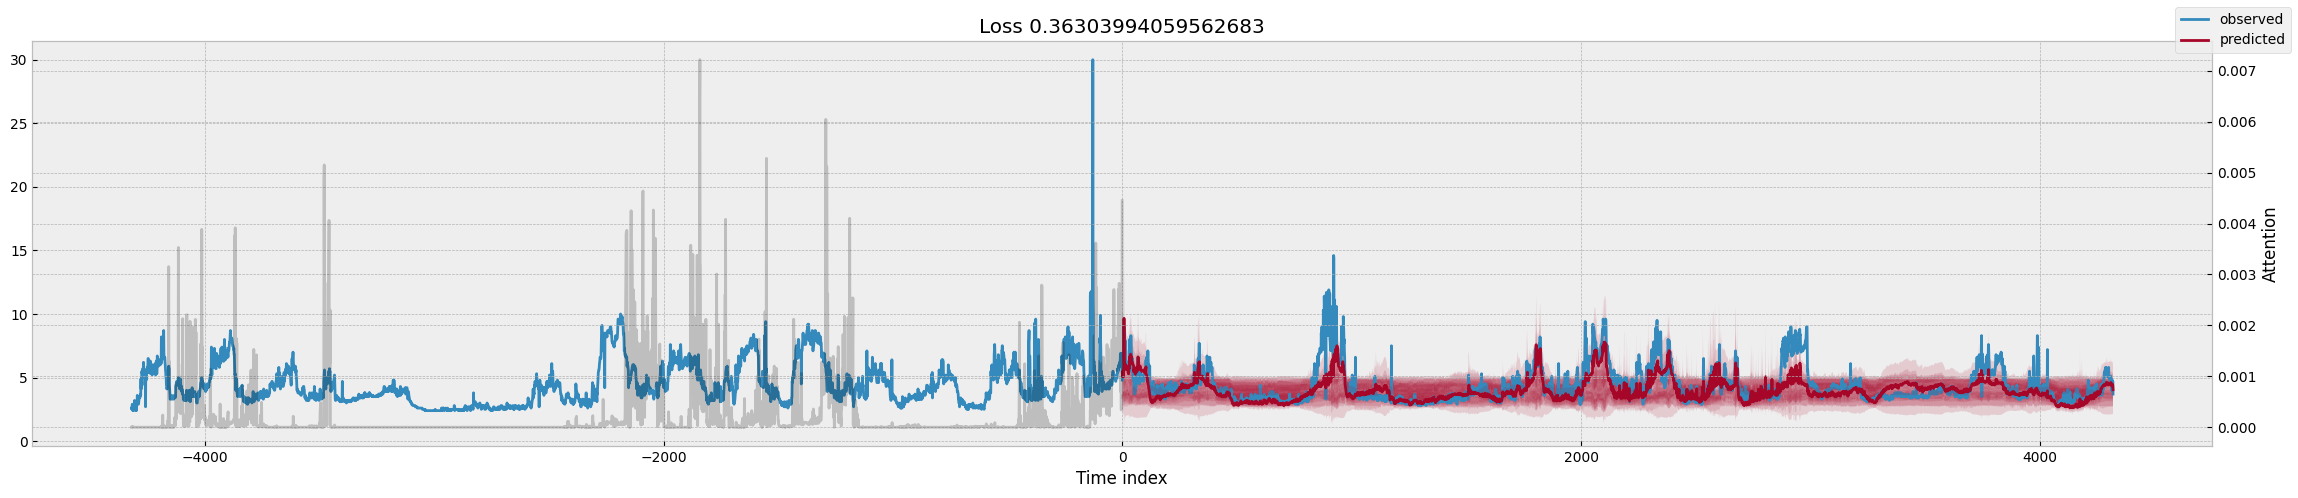

In [79]:
# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
for idx in range(9):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


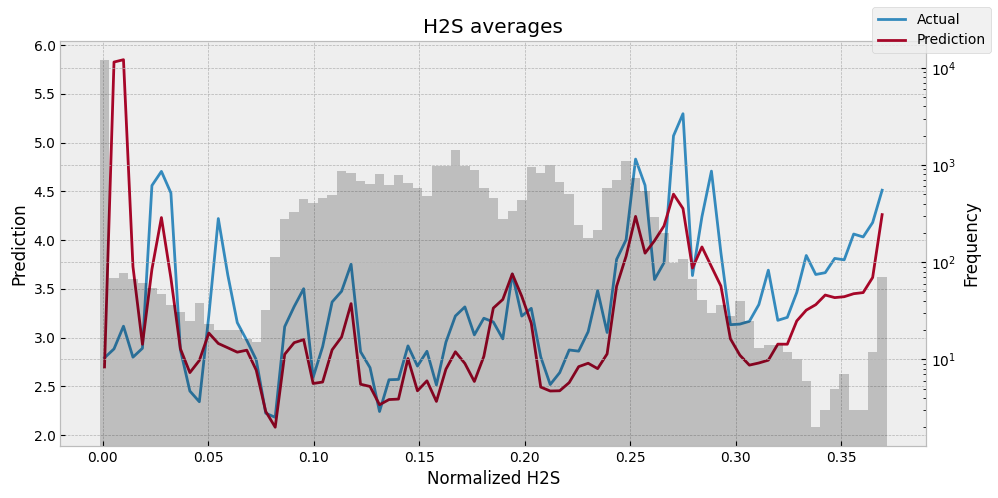

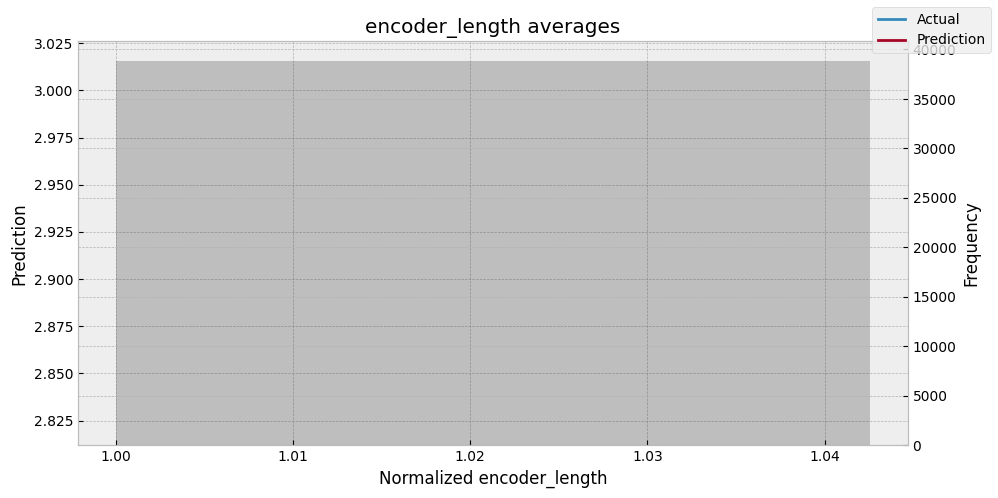

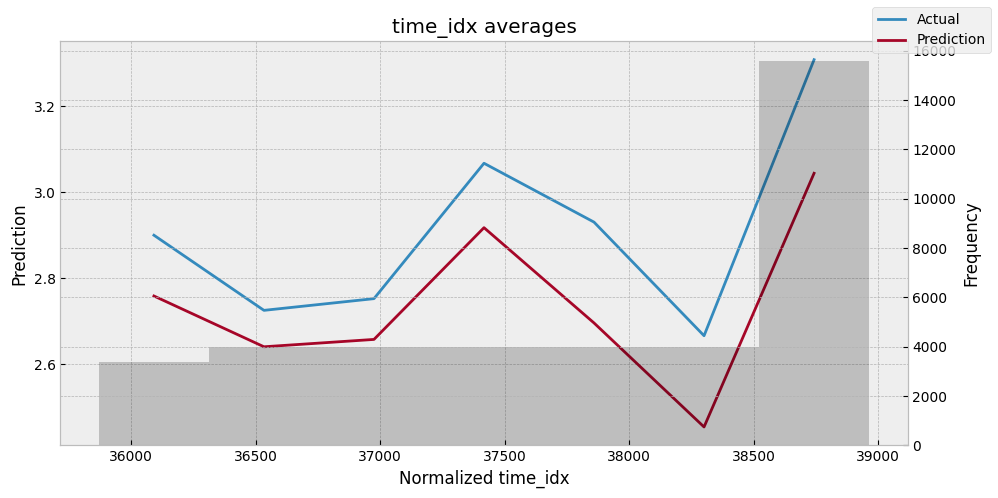

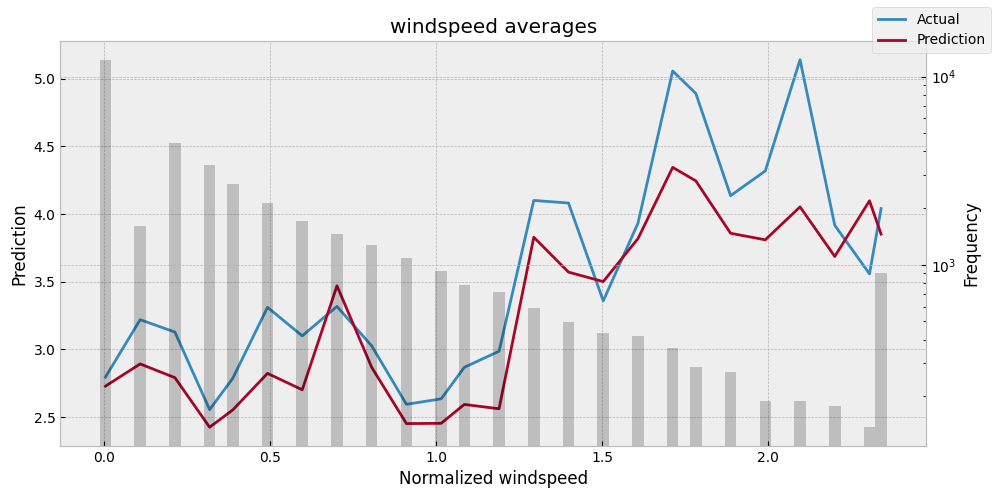

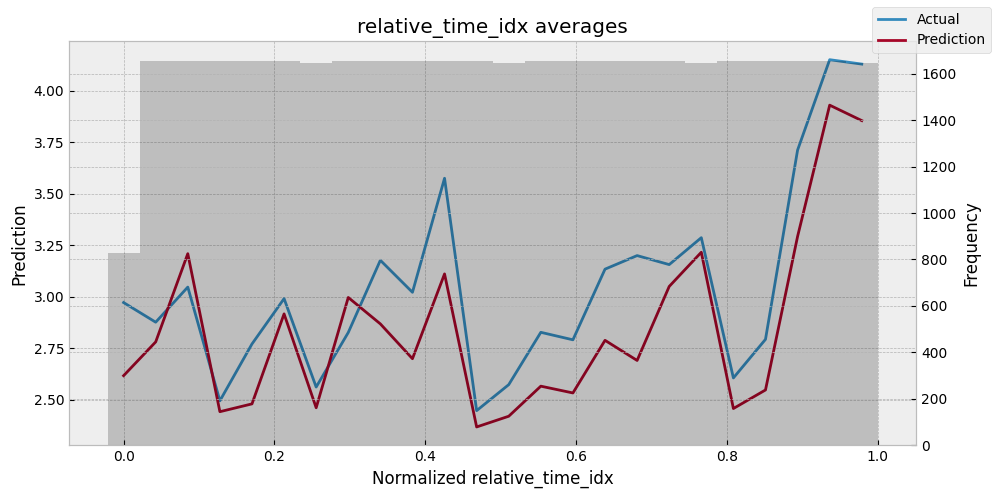

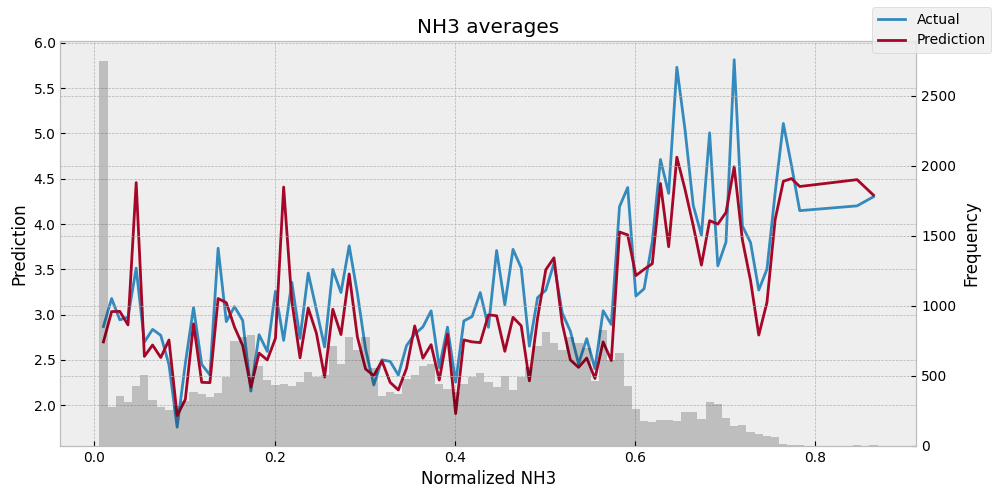

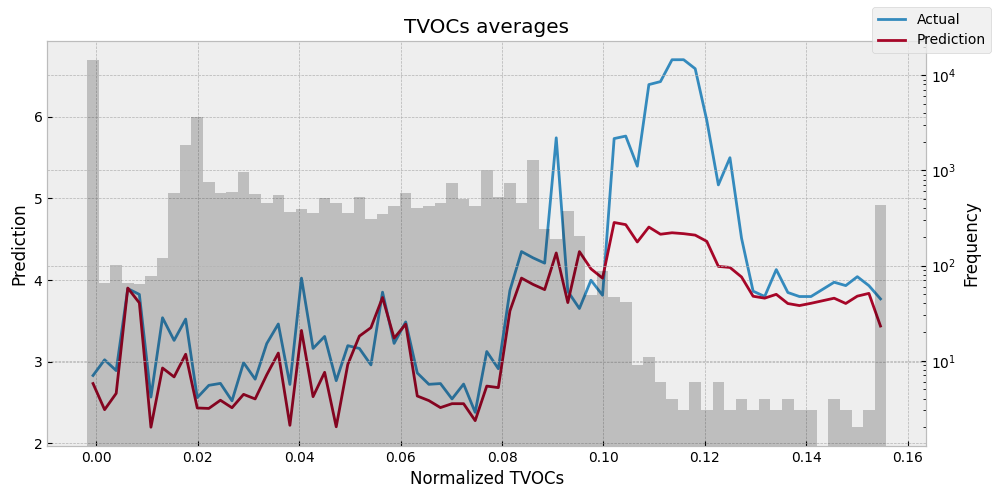

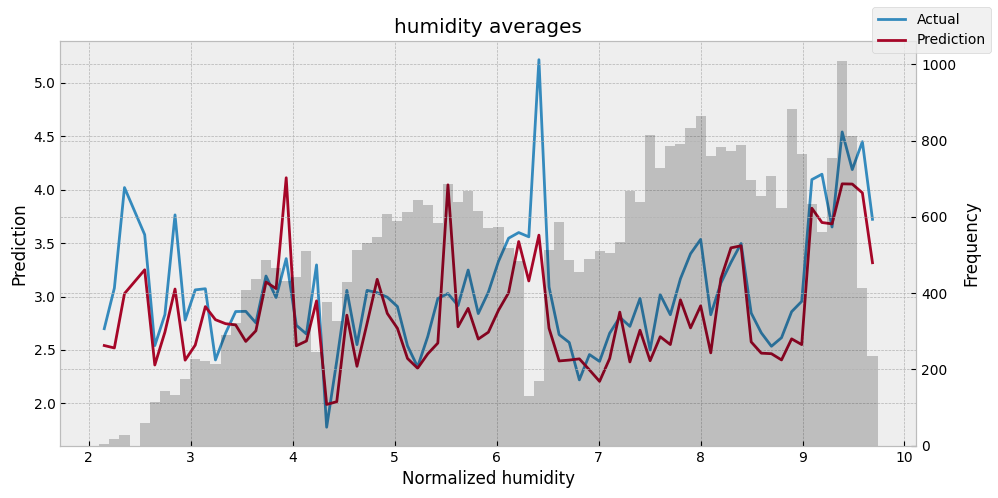

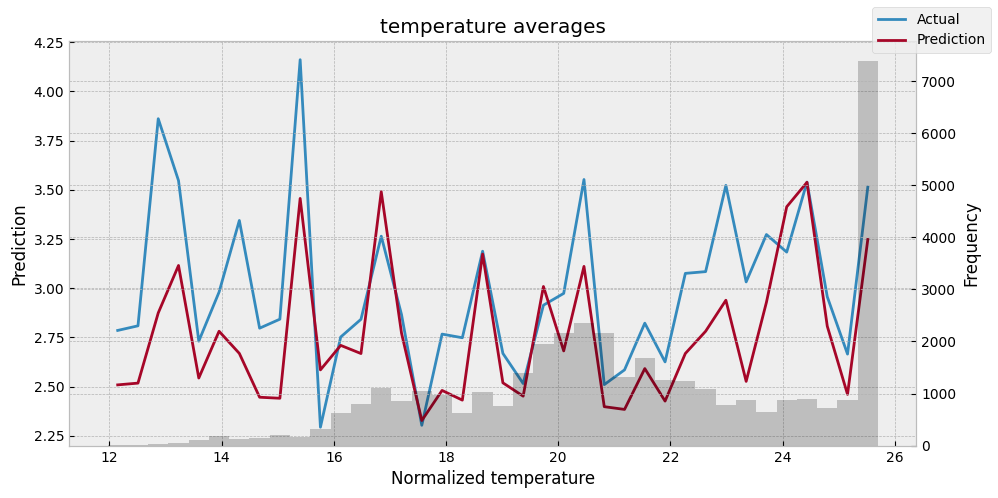

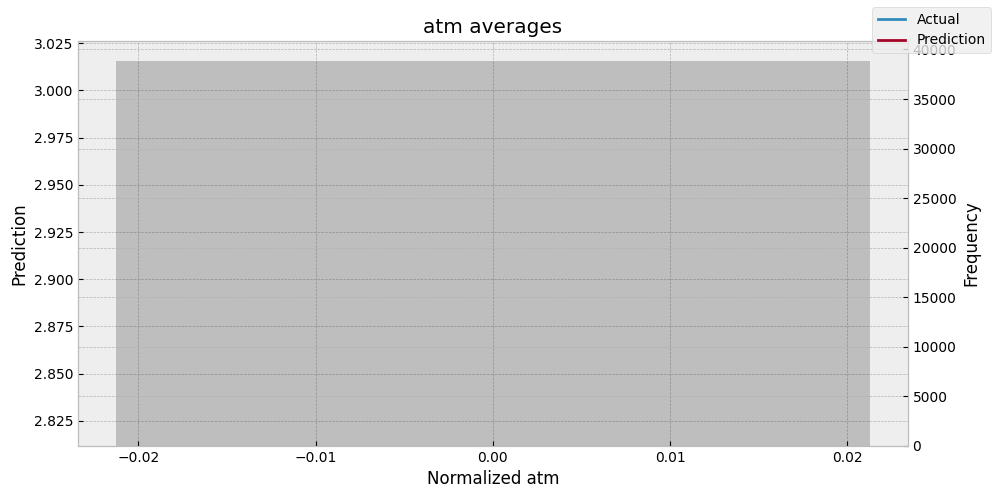

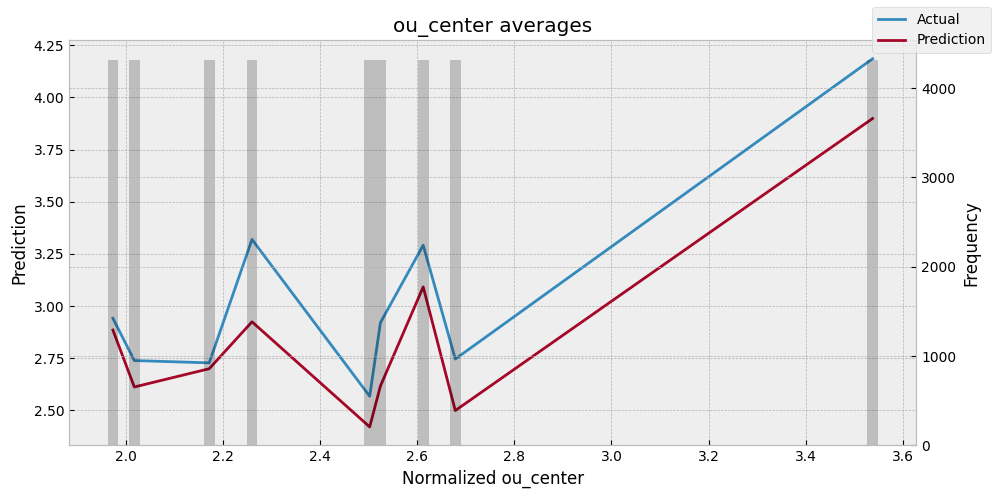

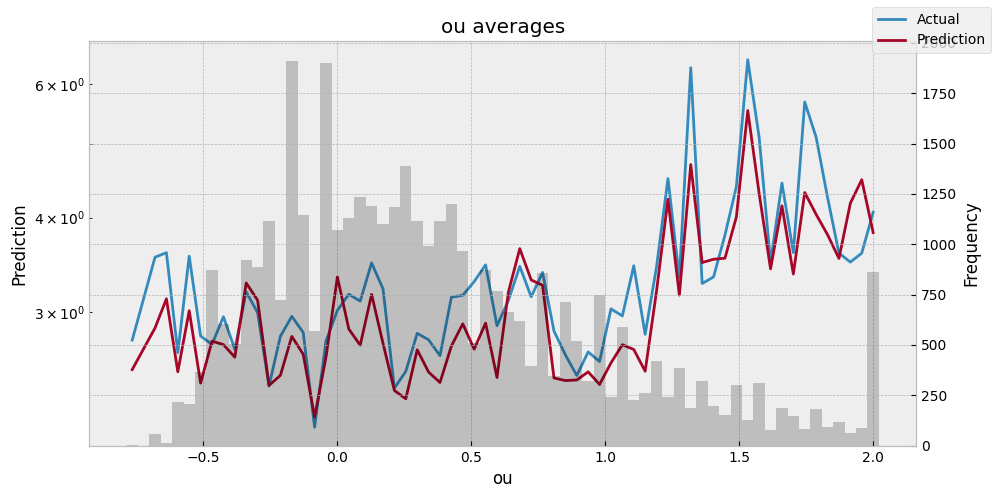

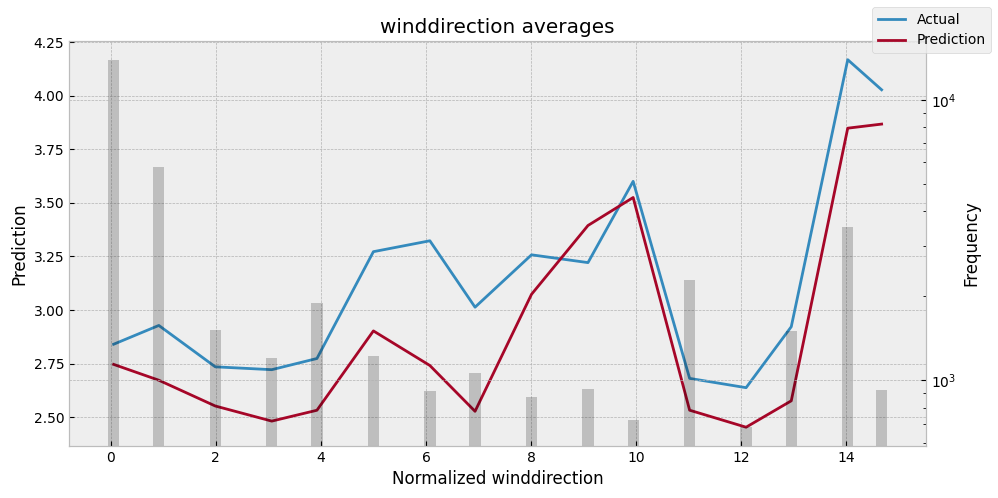

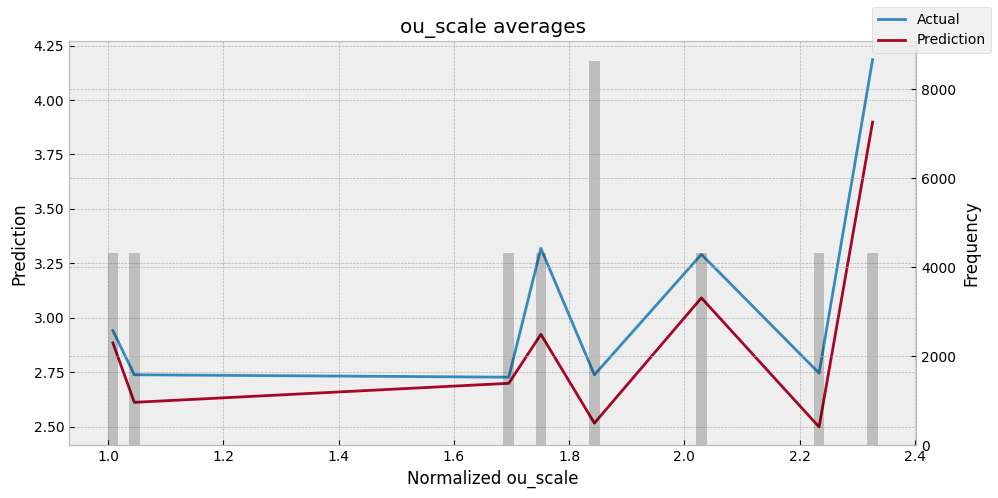

In [42]:
val_prediction_results = best_tft.predict(
    val_dataloader, 
    mode="prediction", # get only median predictions
    return_x=True,
    )
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(val_prediction_results.x, val_prediction_results.output)
features = list(set(predictions_vs_actuals['support'].keys())-set(['ou_lagged_by_141', 'ou_lagged_by_1']))
for feature in features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature)


In [45]:
val_prediction_results.keys()


('output', 'x', 'index', 'decoder_lengths', 'y')

In [47]:
val_prediction_results.output[0]

tensor([2.5476, 2.5478, 2.5283,  ..., 2.9204, 2.9442, 3.0687], device='cuda:0')

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x525 with 1 Axes>,
 'decoder_variables': <Figure size 700x450 with 1 Axes>}

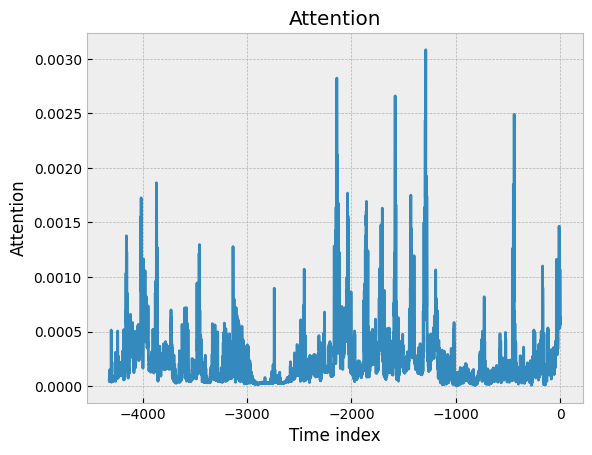

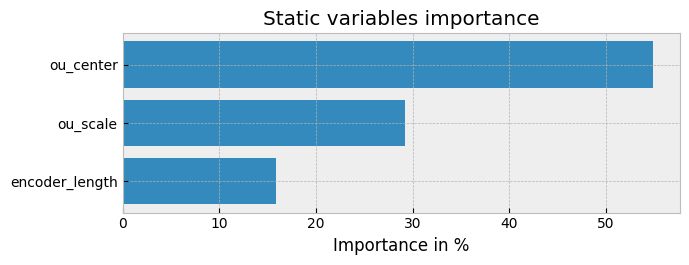

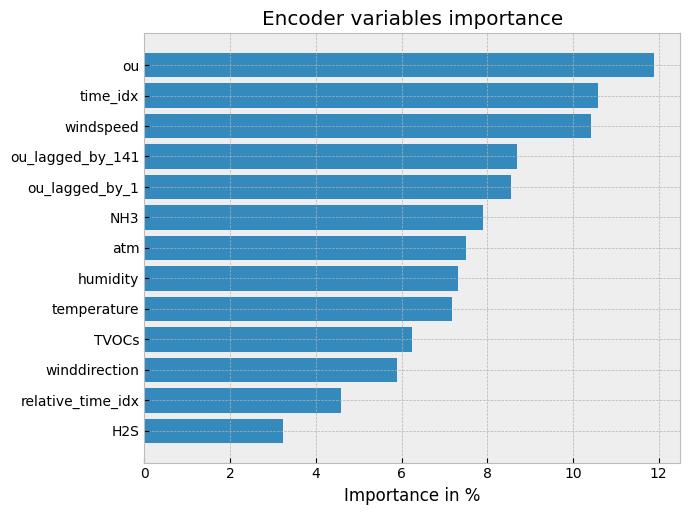

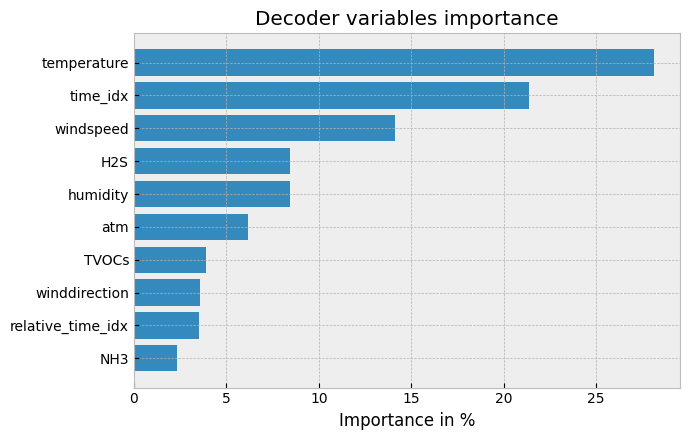

In [80]:
# plot variable importance
interpretation = best_tft.interpret_output(val_prediction_results.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [55]:
test_df['ou'] = 0.0
test = pd.concat([train_df, test_df], ignore_index=True)

/tmp/ipykernel_11464/17056555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ou'] = 0.0


In [59]:
train_df

item_id      time_cleansing    NH3    H2S  TVOCs  temperature  \
0           101 2023-01-11 00:10:00  0.414  0.251  0.094         -1.7   
1           102 2023-01-11 00:10:00  0.667  0.230  0.008         -1.8   
2           103 2023-01-11 00:10:00  0.626  0.267  0.003          0.5   
3           104 2023-01-11 00:10:00  0.285  0.202  0.008         -0.6   
4           105 2023-01-11 00:10:00  0.523  0.303  0.023         -1.4   
...         ...                 ...    ...    ...    ...          ...   
357876      105 2023-05-31 23:55:00  0.328  0.248  0.020         22.0   
357877      106 2023-05-31 23:55:00  0.269  0.135  0.000         21.8   
357878      107 2023-05-31 23:55:00  0.547  0.176  0.017         21.9   
357879      108 2023-05-31 23:55:00  0.000  0.000  0.078         21.6   
357880      109 2023-05-31 23:55:00  0.626  0.000  0.032         21.9   

        humidity  winddirection  windspeed  atm   ou        date  time_idx  
0            8.8              1        0.3    0  1.8  2023-01-11         1  
1            8.9              1        0.3    0  2.2  2023-01-11         1  
2            8.0              0        0.0    0  3.9  2023-01-11         1  
3            8.5              0        0.0    0  1.6  2023-01-11         1  
4            9.0              0        0.0    0  2.3  2023-01-11         1  
...          ...            ...        ...  ...  ...         ...       ...  
357876       7.5             11        0.3    0  2.5  2023-05-31     40254  
357877       7.0              6        0.4    0  2.6  2023-05-31     40254  
357878       7.5              7        0.8    0  2.9  2023-05-31     40254  
357879       7.8              0        0.0    0  2.8  2023-05-31     40254  
357880       7.6              8        1.4    0  3.7  2023-05-31     40254  

[357881 rows x 13 columns]

In [60]:
test

item_id      time_cleansing    NH3    H2S  TVOCs  temperature  \
0           101 2023-01-11 00:10:00  0.414  0.251  0.094         -1.7   
1           102 2023-01-11 00:10:00  0.667  0.230  0.008         -1.8   
2           103 2023-01-11 00:10:00  0.626  0.267  0.003          0.5   
3           104 2023-01-11 00:10:00  0.285  0.202  0.008         -0.6   
4           105 2023-01-11 00:10:00  0.523  0.303  0.023         -1.4   
...         ...                 ...    ...    ...    ...          ...   
436869      105 2023-07-01 23:55:00  0.331  0.245  0.021         25.0   
436870      106 2023-07-01 23:55:00  0.278  0.128  0.000         24.4   
436871      107 2023-07-01 23:55:00  0.559  0.182  0.018         24.5   
436872      108 2023-07-01 23:55:00  0.000  0.000  0.044         24.5   
436873      109 2023-07-01 23:55:00  0.613  0.000  0.021         24.2   

        humidity  winddirection  windspeed  atm   ou        date  time_idx  
0            8.8              1        0.3    0  1.8  2023-01-11         1  
1            8.9              1        0.3    0  2.2  2023-01-11         1  
2            8.0              0        0.0    0  3.9  2023-01-11         1  
3            8.5              0        0.0    0  1.6  2023-01-11         1  
4            9.0              0        0.0    0  2.3  2023-01-11         1  
...          ...            ...        ...  ...  ...         ...       ...  
436869       8.5              7        0.4    0  0.0  2023-07-01     49126  
436870       8.2              0        0.0    0  0.0  2023-07-01     49126  
436871       8.5              0        0.0    0  0.0  2023-07-01     49126  
436872       8.8              0        0.0    0  0.0  2023-07-01     49126  
436873       8.9              1        0.1    0  0.0  2023-07-01     49126  

[436874 rows x 13 columns]

In [52]:
# Create test dataset
test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        test, 
                                        predict=True, 
                                        stop_randomization=True)

In [81]:
# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)


test_prediction_results = best_tft.predict(
    test_dataloader,
    mode="raw",
    return_index=True, # return the prediction index in the same order as the output
    return_x=True, # return network inputs in the same order as prediction output
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [85]:
# test_predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(test_prediction_results.x, test_prediction_results.output)
# best_tft.plot_prediction_actual_by_variable(test_predictions_vs_actuals)

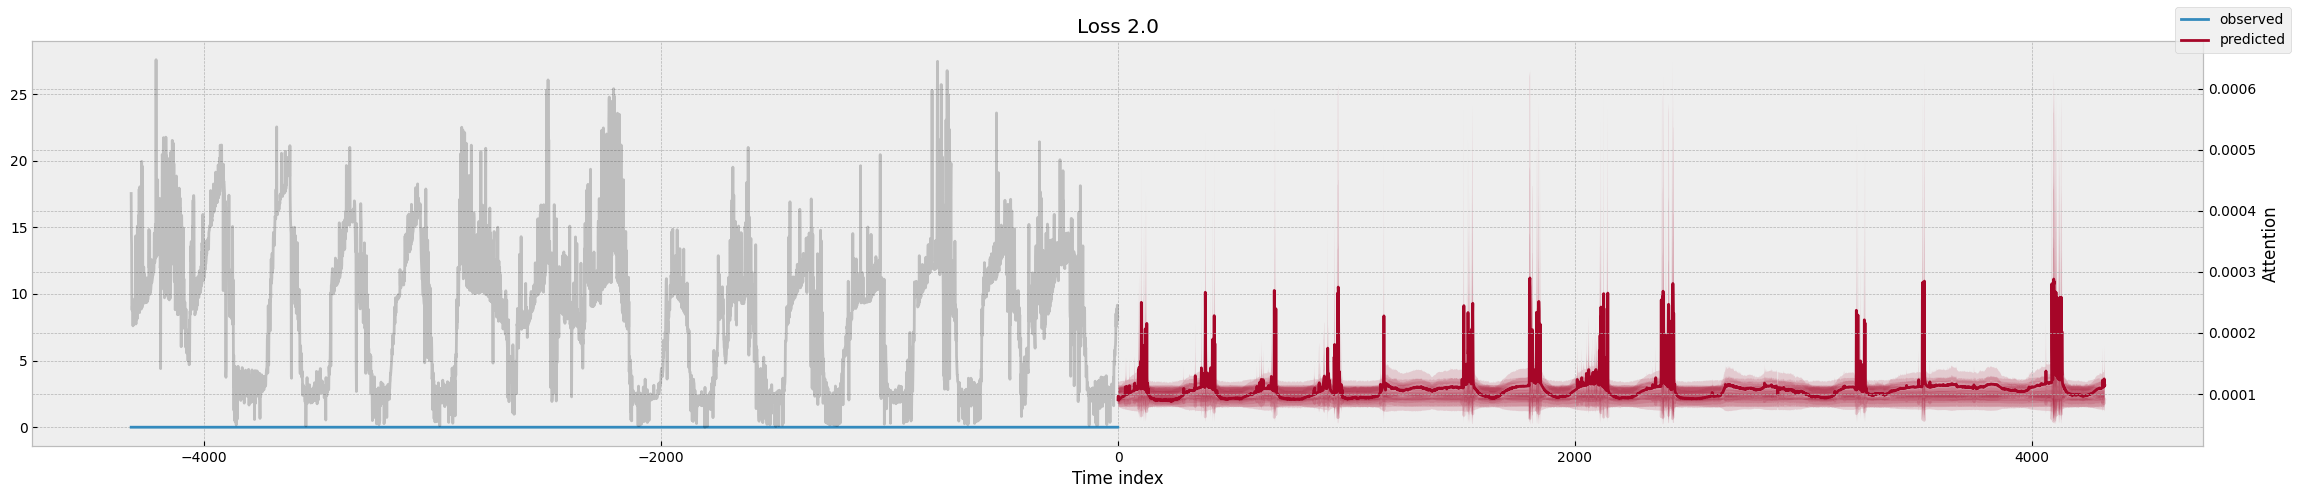

In [84]:
# Plot predictions for year 2021 and attention
# for idx in range(test_prediction_results):
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(
        test_prediction_results.x, 
        test_prediction_results.output, 
        idx=idx, 
        show_future_observed=False,
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
        ax=ax,
        )

In [62]:
test_prediction_results.output

Output(prediction=tensor([[[1.6438, 1.7886, 1.9266,  ..., 2.4734, 2.1506, 2.3330],
         [1.7579, 1.9455, 2.1298,  ..., 2.3278, 2.1027, 2.3658],
         [1.6355, 1.7721, 1.8865,  ..., 2.4548, 2.1491, 2.3539],
         ...,
         [2.6371, 2.9745, 3.2814,  ..., 2.0090, 1.9022, 2.0260],
         [2.3955, 2.6747, 2.8824,  ..., 2.2085, 2.1173, 2.0124],
         [2.4118, 2.6937, 2.9111,  ..., 2.2093, 2.0984, 1.9907]],

        [[1.5417, 1.6869, 1.9134,  ..., 2.5915, 2.1377, 2.6196],
         [1.5083, 1.6291, 1.8054,  ..., 2.6277, 2.1710, 2.6546],
         [1.4721, 1.5740, 1.7222,  ..., 2.6660, 2.2027, 2.6599],
         ...,
         [3.5242, 4.6733, 5.4715,  ..., 2.2945, 0.9179, 2.5556],
         [3.5428, 4.6948, 5.4960,  ..., 2.2872, 0.9214, 2.5445],
         [3.5508, 4.7119, 5.5242,  ..., 2.2707, 0.9164, 2.5579]],

        [[1.2074, 1.3484, 1.4817,  ..., 2.7079, 2.5177, 2.4576],
         [1.2158, 1.3531, 1.4746,  ..., 2.7117, 2.5210, 2.4508],
         [1.2345, 1.3679, 1.4892,  ..., 